# Demand Segmentation

This notebook provides a **statistics-driven demand segmentation** pipeline for the *Online Retail II* dataset.

We focus on weekly revenue series (bin = **7 days**) and classify **Top 2000** `product_family_name` items using industry-standard intermittent-demand metrics:

- **ADI** (Average Demand Interval)
- **CV²** (Squared Coefficient of Variation on non-zero demand)
- **Seasonality strength** (via **STL** decomposition)
- **Spike score** (robust peak-to-typical ratio)

> To keep categories simple, we output a **3-class segment** (Regular / Intermittent / Lumpy) and keep seasonality & spike as **separate scores/flags** (not exploding the number of classes).

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

pd.set_option("display.max_columns", 200)

## 1) Load data 

In [ ]:
BASE_DIR = Path("Online_Retail_Forecasting")
DATA_DIR = Path('data')

p1 = DATA_DIR / "Year_2009-2010_post.parquet"
p2 = DATA_DIR / "Year_2010-2011_post.parquet"

assert p1.exists(), f"File not found: {p1}"
assert p2.exists(), f"File not found: {p2}"

df1 = pd.read_parquet(p1)
df2 = pd.read_parquet(p2)
df = pd.concat([df1, df2], ignore_index=True)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# revenue (weekly target)
df["revenue"] = df["Quantity"] * df["Price"]

# minimal cleansing (industry standard for Online Retail-style data)
df = df[df["Price"] > 0]      # remove invalid prices

df = df.sort_values("InvoiceDate")

df.shape

(1061164, 11)

## 2) Select Top 2000 product families

We segment the **Top 2000** `product_family_name` by total revenue across the full history.

In [16]:
topN = 2000

top_items = (
    df.groupby("product_family_name")["revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(topN)
      .index
)

df_top = df[df["product_family_name"].isin(top_items)].copy()

df_top["product_family_name"].nunique(), df_top.shape

(2000, (1049144, 11))

## 3) Aggregate to weekly revenue (bin = 7 days)

We use weekly bins because:
- it reduces transaction noise
- it aligns with common retail planning cadence

In [17]:
weekly = (
    df_top.groupby(["product_family_name", pd.Grouper(key="InvoiceDate", freq="W")])["revenue"]
          .sum()
          .reset_index()
)

weekly.head()

,product_family_name,InvoiceDate,revenue
0,10 COLOUR SPACEBOY PEN,2010-05-09,195.48
1,10 COLOUR SPACEBOY PEN,2010-05-16,153.85
2,10 COLOUR SPACEBOY PEN,2010-05-23,83.26
3,10 COLOUR SPACEBOY PEN,2010-05-30,231.16
4,10 COLOUR SPACEBOY PEN,2010-06-06,135.92


## 4) Feature helpers

### 4.1 ADI and CV² (Syntetos–Boylan metrics)

- **ADI = T / Nₙz** where T is number of weeks and Nₙz is number of non-zero weeks.
- **CV² = (σ/μ)²** computed on **non-zero** weeks to measure magnitude variability when demand occurs.

### 4.2 Seasonality strength (STL)

We use yearly seasonality at weekly frequency: **period = 52**.

$$
F_s = 1 - \frac{Var(resid)}{Var(resid + seasonal)}
$$

### 4.3 Spike score (robust)

Your earlier max/median score can over-flag sparse series because median can be 0.  
Here we compute:

- **baseline = median(nonzero)**
- **peak = P95(all weeks)** (more robust than max)
- **spike_score = peak / baseline**

In [18]:
def complete_weekly_index(ts: pd.Series) -> pd.Series:
    # Reindex to complete weekly grid and fill missing weeks with 0.
    ts = ts.sort_index()
    full_idx = pd.date_range(ts.index.min(), ts.index.max(), freq="W")
    return ts.reindex(full_idx, fill_value=0.0)


def compute_adi_cv2(ts: pd.Series):
    ts = complete_weekly_index(ts)
    T = len(ts)
    nonzero = ts[ts > 0]
    nz = len(nonzero)
    if nz == 0:
        return T, nz, np.inf, np.nan

    ADI = T / nz

    mu = nonzero.mean()
    sigma = nonzero.std(ddof=1) if nz > 1 else 0.0
    CV2 = (sigma / mu) ** 2 if mu > 0 else np.inf
    return T, nz, ADI, CV2


def seasonality_strength_stl(ts: pd.Series, period: int = 52) -> float:
    ts = complete_weekly_index(ts)
    if len(ts) < period:
        return 0.0

    try:
        res = STL(ts, period=period, robust=True).fit()
        denom = np.var(res.resid + res.seasonal)
        if denom <= 0:
            return 0.0
        return float(1 - (np.var(res.resid) / denom))
    except Exception:
        return 0.0


def spike_score(ts: pd.Series, min_nz: int = 4) -> float:
    # Robust spike score: P95(all weeks) / median(nonzero). Returns NaN if too sparse.
    ts = complete_weekly_index(ts)
    nonzero = ts[ts > 0]
    if len(nonzero) < min_nz:
        return np.nan

    baseline = float(nonzero.median())
    peak = float(np.quantile(ts, 0.95))
    return peak / (baseline + 1e-6)


def ljung_box_pvalue(ts: pd.Series, max_lag: int = 12) -> float:
    # Optional: autocorrelation test. Returns p-value at adaptive max_lag.
    ts = complete_weekly_index(ts)
    n = len(ts)
    lag = min(max_lag, n - 1)
    if lag < 2:
        return 1.0
    out = acorr_ljungbox(ts, lags=[lag], return_df=True)
    return float(out["lb_pvalue"].iloc[0])

## 5) Build a simple **3-class** segment

To avoid too many labels, we use **only ADI & CV²** for the main segment and keep seasonality/spike as separate diagnostics.

### Segment rule (compact)

- **Regular**: ADI ≤ 1.32  
- **Intermittent**: ADI > 1.32 and CV² ≤ 0.49  
- **Lumpy (Long-tail)**: ADI > 1.32 and CV² > 0.49  

> We also keep a separate `erratic_flag = (ADI ≤ 1.32 and CV² > 0.49)` but do **not** make it a separate class.

In [19]:
ADI_TH = 1.32
CV2_TH = 0.49

SEASON_TH = 0.30   # seasonality strength threshold
SPIKE_TH = 5.0     # spike score threshold (robust P95/median_nonzero)

rows = []
for name, g in weekly.groupby("product_family_name"):
    ts = g.set_index("InvoiceDate")["revenue"]

    T, nz, ADI, CV2 = compute_adi_cv2(ts)
    seas = seasonality_strength_stl(ts, period=52)
    spk = spike_score(ts, min_nz=4)
    lb_p = ljung_box_pvalue(ts, max_lag=12)  # optional diagnostic

    # main 3-class segment
    if ADI <= ADI_TH:
        segment = "regular"
    else:
        segment = "intermittent" if (CV2 <= CV2_TH) else "lumpy"

    # side flags (do not explode classes)
    erratic_flag = (ADI <= ADI_TH) and (CV2 > CV2_TH)
    seasonal_flag = (seas >= SEASON_TH)
    spike_flag = (pd.notna(spk) and (spk >= SPIKE_TH))

    rows.append({
        "product_family_name": name,
        "weeks_T": T,
        "nonzero_weeks_nz": nz,
        "ADI": ADI,
        "CV2": CV2,
        "segment_3class": segment,
        "erratic_flag": erratic_flag,
        "seasonality_strength": seas,
        "seasonal_flag": seasonal_flag,
        "spike_score": spk,
        "spike_flag": spike_flag,
        "ljung_box_pvalue": lb_p,
    })

seg_df = pd.DataFrame(rows)

seg_df.head()

,product_family_name,weeks_T,nonzero_weeks_nz,ADI,CV2,segment_3class,erratic_flag,seasonality_strength,seasonal_flag,spike_score,spike_flag,ljung_box_pvalue
0,10 COLOUR SPACEBOY PEN,84,81,1.037037,0.508470,regular,True,0.496720,True,2.834547,False,4.756376e-04
1,12 ASS ZINC CHRISTMAS DECORATIONS,45,21,2.142857,0.780177,lumpy,False,0.000000,False,3.908393,False,1.370702e-01
2,12 COLOURED PARTY BALLOONS,88,81,1.086420,1.648088,regular,True,0.036741,False,2.221951,False,9.992757e-01
3,12 DAISY PEGS IN WOOD BOX,98,80,1.225000,1.531179,regular,True,0.238485,False,5.570562,True,6.157187e-01
4,12 MESSAGE CARDS WITH ENVELOPES,65,62,1.048387,1.904682,regular,True,0.449396,True,5.989143,True,1.611756e-07


## 6) Summary tables

We inspect:
- segment counts
- seasonality/spike proportions within each segment

In [20]:
seg_df["segment_3class"].value_counts()

segment_3class
regular         1158
lumpy            780
intermittent      62
Name: count, dtype: int64

In [21]:
summary = (
    seg_df.groupby("segment_3class")
          .agg(
              n_items=("product_family_name", "count"),
              median_ADI=("ADI", "median"),
              median_CV2=("CV2", "median"),
              pct_erratic=("erratic_flag", "mean"),
              pct_seasonal=("seasonal_flag", "mean"),
              pct_spike=("spike_flag", "mean"),
              median_season_strength=("seasonality_strength", "median"),
              median_spike_score=("spike_score", "median"),
          )
          .sort_values("n_items", ascending=False)
)
summary

,n_items,median_ADI,median_CV2,pct_erratic,pct_seasonal,pct_spike,median_season_strength,median_spike_score
segment_3class,,,,,,,,
regular,1158,1.056080,0.945785,0.827288,0.618307,0.230570,0.642593,3.708046
lumpy,780,1.844952,1.346275,0.000000,0.603846,0.233333,0.598165,3.453361
intermittent,62,2.032258,0.419688,0.000000,0.596774,0.000000,0.475021,2.000000


## 7) Diagnostic plots (distributions)

These plots help validate whether the segmentation logic is behaving sensibly.

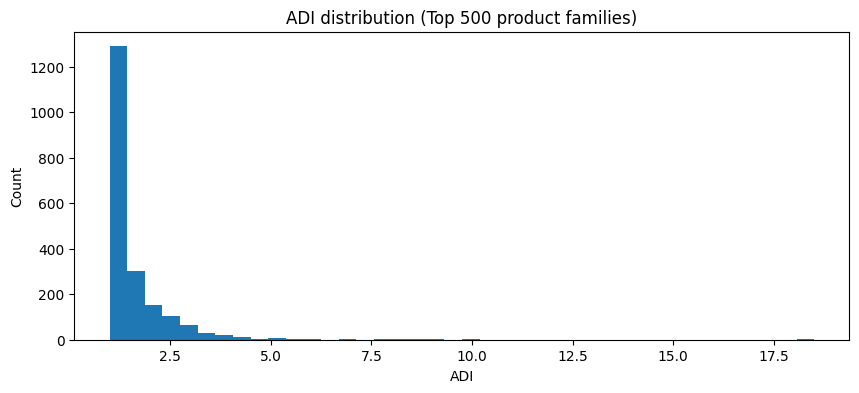

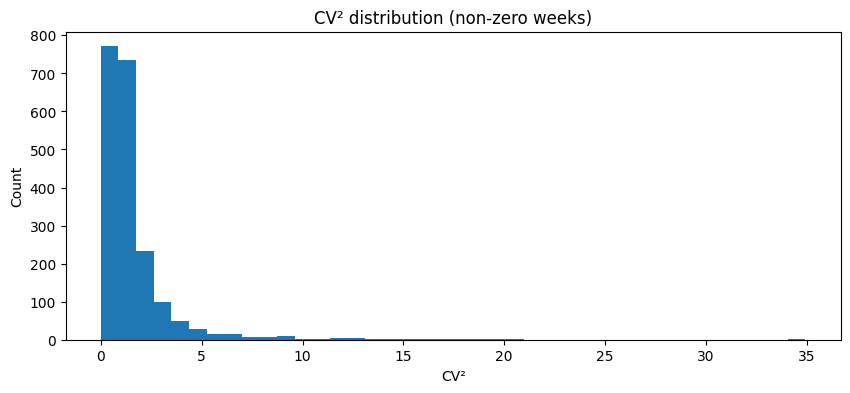

In [22]:
plt.figure(figsize=(10,4))
plt.hist(seg_df["ADI"].replace([np.inf], np.nan).dropna(), bins=40)
plt.title("ADI distribution (Top 500 product families)")
plt.xlabel("ADI")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(seg_df["CV2"].replace([np.inf], np.nan).dropna(), bins=40)
plt.title("CV² distribution (non-zero weeks)")
plt.xlabel("CV²")
plt.ylabel("Count")
plt.show()

## 8) Visualize example time series per segment

We plot a few examples per segment (and annotate flags).

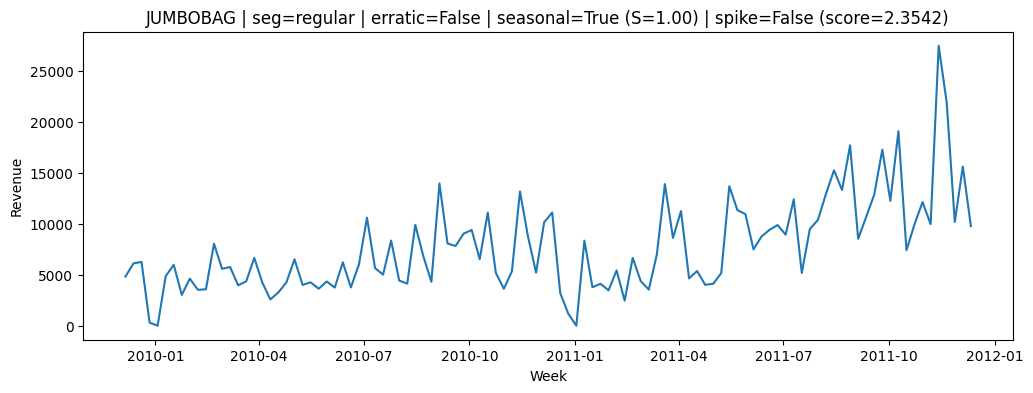

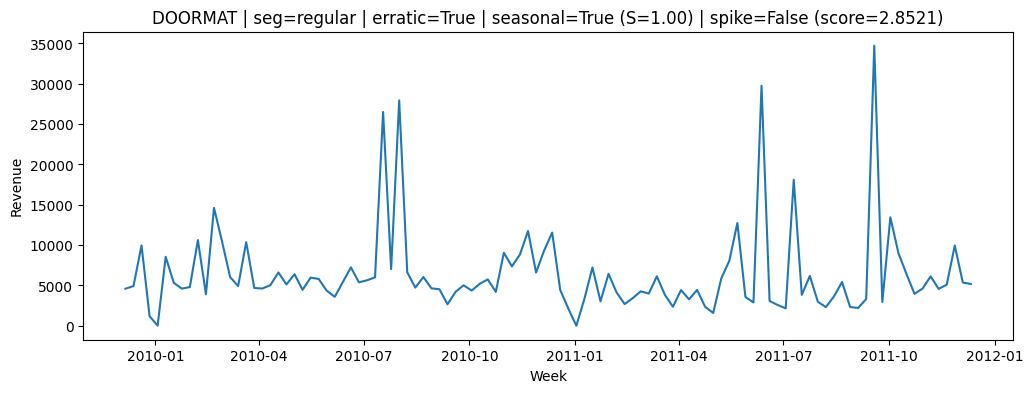

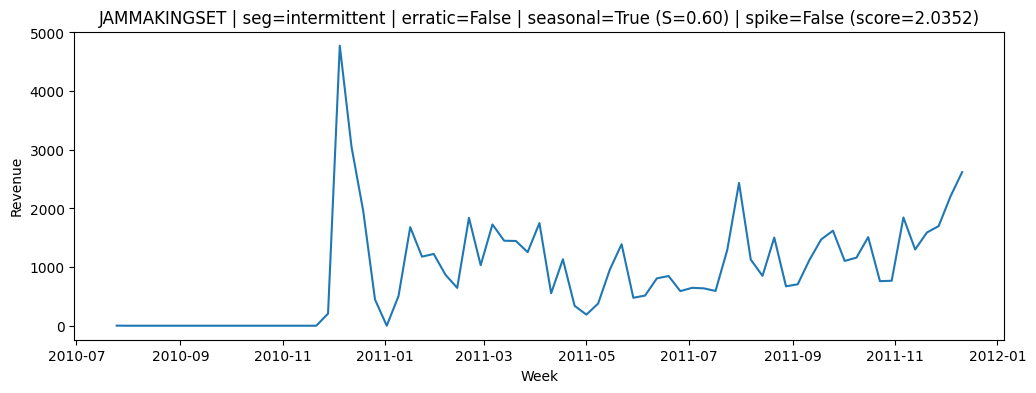

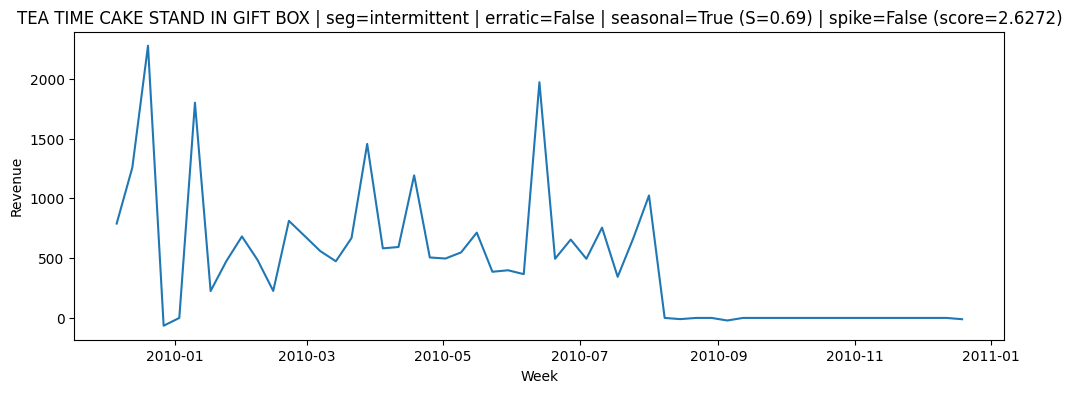

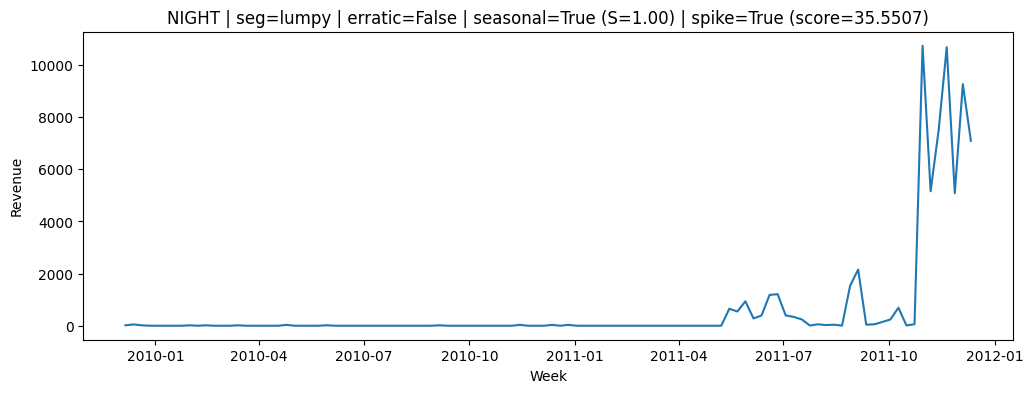

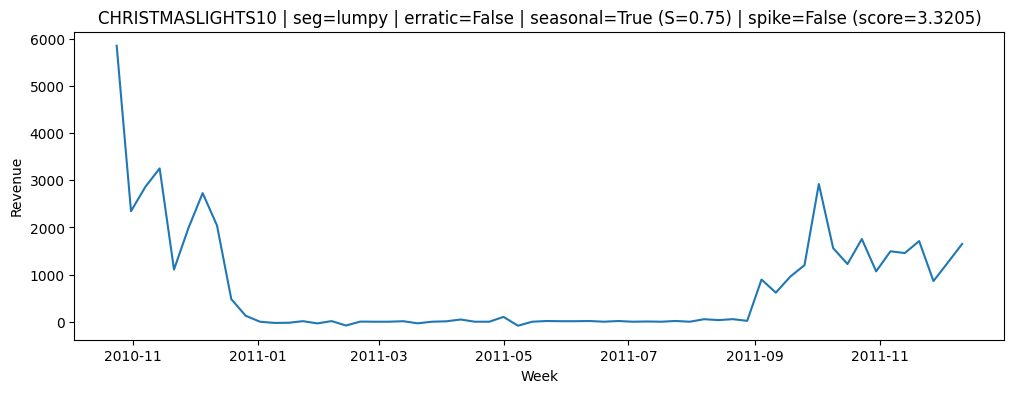

In [27]:
def plot_examples(segment: str, k: int = 3):
    subset = seg_df[seg_df["segment_3class"] == segment].copy()
    if subset.empty:
        print(f"No items for segment={segment}")
        return

    # pick by total revenue (more interpretable)
    totals = df_top.groupby("product_family_name")["revenue"].sum()
    subset["total_revenue"] = subset["product_family_name"].map(totals)
    subset = subset.sort_values("total_revenue", ascending=False)

    for name in subset["product_family_name"].head(k):
        ts = weekly[weekly["product_family_name"] == name].set_index("InvoiceDate")["revenue"]
        ts = complete_weekly_index(ts)

        row = seg_df[seg_df["product_family_name"] == name].iloc[0]
        title = (
            f"{name} | seg={row['segment_3class']}"
            f" | erratic={row['erratic_flag']}"
            f" | seasonal={row['seasonal_flag']} (S={row['seasonality_strength']:.2f})"
            f" | spike={row['spike_flag']} (score={row['spike_score'] if pd.notna(row['spike_score']) else 'NA':.4f})"
        )

        plt.figure(figsize=(12,4))
        plt.plot(ts)
        plt.title(title)
        plt.xlabel("Week")
        plt.ylabel("Revenue")
        plt.show()

plot_examples("regular", k=2)
plot_examples("intermittent", k=2)
plot_examples("lumpy", k=2)

## 9) Export segmentation results (for modeling stage)

We save the segmentation table for later model assignment.

In [25]:
OUT = DATA_DIR / "segment_results_top2000_stats.parquet"
seg_df.to_parquet(OUT, index=False)
print("Saved:", OUT)

Saved: data/segment_results_top2000_stats.parquet


In [28]:
saved_df = pd.read_parquet(OUT)
saved_df.head()

,product_family_name,weeks_T,nonzero_weeks_nz,ADI,CV2,segment_3class,erratic_flag,seasonality_strength,seasonal_flag,spike_score,spike_flag,ljung_box_pvalue
0,10 COLOUR SPACEBOY PEN,84,81,1.037037,0.508470,regular,True,0.496720,True,2.834547,False,4.756376e-04
1,12 ASS ZINC CHRISTMAS DECORATIONS,45,21,2.142857,0.780177,lumpy,False,0.000000,False,3.908393,False,1.370702e-01
2,12 COLOURED PARTY BALLOONS,88,81,1.086420,1.648088,regular,True,0.036741,False,2.221951,False,9.992757e-01
3,12 DAISY PEGS IN WOOD BOX,98,80,1.225000,1.531179,regular,True,0.238485,False,5.570562,True,6.157187e-01
4,12 MESSAGE CARDS WITH ENVELOPES,65,62,1.048387,1.904682,regular,True,0.449396,True,5.989143,True,1.611756e-07
